In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
import torch.nn.utils.rnn as rnn_utils
import time
import pickle
from termcolor import colored

In [3]:
def genData(file,max_len):
    aa_dict={'A':1,'R':2,'N':3,'D':4,'C':5,'Q':6,'E':7,'G':8,'H':9,'I':10,
             'L':11,'K':12,'M':13,'F':14,'P':15,'O':16,'S':17,'U':18,'T':19,
             'W':20,'Y':21,'V':22,'X':23}
    with open(file, 'r') as inf:
        lines = inf.read().splitlines()
        
    long_pep_counter=0
    pep_codes=[]
    labels=[]
    for pep in lines:
        pep,label=pep.split(",")
        labels.append(int(label))
        if not len(pep) > max_len:
            current_pep=[]
            for aa in pep:
                current_pep.append(aa_dict[aa])
            pep_codes.append(torch.tensor(current_pep))
        else:
            long_pep_counter += 1
    print("length > 81:",long_pep_counter)
    data = rnn_utils.pad_sequence(pep_codes,batch_first=True)
    return data,torch.tensor(labels)


In [4]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        acc_sum += (outputs.argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def to_log(log):
    with open("../compareModel/2021ACS_PepFormer/modelLog.log","a+") as f:
        f.write(log+'\n')

In [5]:
def collate(batch):
    seq1_ls=[]
    seq2_ls=[]
    label1_ls=[]
    label2_ls=[]
    label_ls=[]
    batch_size=len(batch)
    for i in range(int(batch_size/2)):
        seq1,label1=batch[i][0],batch[i][1]
        seq2,label2=batch[i+int(batch_size/2)][0],batch[i+int(batch_size/2)][1]
        label1_ls.append(label1.unsqueeze(0))
        label2_ls.append(label2.unsqueeze(0))
        label=(label1^label2)
        seq1_ls.append(seq1.unsqueeze(0))
        seq2_ls.append(seq2.unsqueeze(0))
        label_ls.append(label.unsqueeze(0))
    seq1=torch.cat(seq1_ls).to(device)
    seq2=torch.cat(seq2_ls).to(device)
    label=torch.cat(label_ls).to(device)
    label1=torch.cat(label1_ls).to(device)
    label2=torch.cat(label2_ls).to(device)
    return seq1,seq2,label,label1,label2

# New Train

# 1. Make Data X_train, y_train, X_test, y_test

In [6]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train_noptm_210930_includeDigest.csv')
df_detect_peptide_test = pd.read_csv('../data/df_detect_peptide_test_noptm_210930_includeDigest.csv')

tra, val = train_test_split(df_detect_peptide_train[['PEP', 'ID']], test_size=0.2, random_state=7)
tra.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv', header=False, index=False)
val.to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv', header=False, index=False)
df_detect_peptide_test[['PEP', 'ID']].to_csv('../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv', header=False, index=False)

In [7]:
train_data,train_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_train_noptm_includeDigest.csv",81)
print(train_data.shape, train_label.shape)
train_dataset = Data.TensorDataset(train_data, train_label)

val_data,val_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_val_noptm_includeDigest.csv",81)
print(val_data.shape, val_label.shape)
val_dataset = Data.TensorDataset(val_data, val_label)

test_data,test_label=genData("../compareModel/2021ACS_PepFormer/detect_peptide_test_noptm_includeDigest.csv",81)
print(test_data.shape, test_label.shape)
test_dataset = Data.TensorDataset(test_data, test_label)

batch_size=256
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_iter_cont = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                                                  shuffle=True, collate_fn=collate)
val_iter = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

length > 81: 0
torch.Size([337179, 30]) torch.Size([337179])
length > 81: 0
torch.Size([84295, 30]) torch.Size([84295])
length > 81: 0
torch.Size([88998, 30]) torch.Size([88998])


# 2. train

In [8]:
device = torch.device("cuda",0)

In [9]:
class newModel(nn.Module):
    def __init__(self, vocab_size=24):
        super().__init__()
        self.hidden_dim = 25
        self.batch_size = 256
        self.emb_dim = 512
        
        self.embedding = nn.Embedding(vocab_size, self.emb_dim, padding_idx=0)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.gru = nn.GRU(self.emb_dim, self.hidden_dim, num_layers=2, 
                               bidirectional=True, dropout=0.2)
        
        
        self.block1=nn.Sequential(nn.Linear(1600,1024),
                                            nn.BatchNorm1d(1024),
                                            nn.LeakyReLU(),
                                            nn.Linear(1024,256),
                                 )

        self.block2=nn.Sequential(
                                               nn.BatchNorm1d(256),
                                               nn.LeakyReLU(),
                                               nn.Linear(256,128),
                                               nn.BatchNorm1d(128),
                                               nn.LeakyReLU(),
                                               nn.Linear(128,64),
                                               nn.BatchNorm1d(64),
                                               nn.LeakyReLU(),
                                               nn.Linear(64,2)
                                            )
        
    def forward(self, x):
        x=self.embedding(x)
        output=self.transformer_encoder(x).permute(1, 0, 2)
        output,hn=self.gru(output)
        output=output.permute(1,0,2)
        hn=hn.permute(1,0,2)
        output=output.reshape(output.shape[0],-1)
        hn=hn.reshape(output.shape[0],-1)
        output=torch.cat([output,hn],1)
#         print(output.shape,hn.shape)
        return self.block1(output)

    def trainModel(self, x):
        with torch.no_grad():
            output=self.forward(x)
        return self.block2(output)


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # euclidean_distance: [128]
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +     # calmp夹断用法
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))     
        
        return loss_contrastive

In [10]:
for num_model in range(2):
    net=newModel().to(device)
    lr = 0.0001
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=5e-4)
    criterion = ContrastiveLoss()
    criterion_model = nn.CrossEntropyLoss(reduction='sum')
    best_acc=0
    EPOCH=250
    for epoch in range(EPOCH):
        loss_ls=[]
        loss1_ls=[]
        loss2_3_ls=[]
        t0=time.time()
        net.train()
        for seq1,seq2,label,label1,label2 in train_iter_cont:
                output1=net(seq1)
                output2=net(seq2)
                output3=net.trainModel(seq1)
                output4=net.trainModel(seq2)
                loss1=criterion(output1, output2, label)
                loss2=criterion_model(output3,label1)
                loss3=criterion_model(output4,label2)
                loss=loss1+loss2+loss3
    #             print(loss)
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                loss_ls.append(loss.item())
                loss1_ls.append(loss1.item())
                loss2_3_ls.append((loss2+loss3).item())


        net.eval() 
        with torch.no_grad(): 
            train_acc=evaluate_accuracy(train_iter,net)
            test_acc=evaluate_accuracy(test_iter,net)
        results=f"epoch: {epoch+1}, loss: {np.mean(loss_ls):.5f}, loss1: {np.mean(loss1_ls):.5f}, loss2_3: {np.mean(loss2_3_ls):.5f}\n"
        results+=f'\ttrain_acc: {train_acc:.4f}, test_acc: {colored(test_acc,"red")}, time: {time.time()-t0:.2f}'
        print(results)
#         to_log(results)
        if test_acc>best_acc:
            best_acc=test_acc
#             torch.save({"best_acc":best_acc,"model":net.state_dict()},f'./Model/{num_model}.pl')
            print(f"best_acc: {best_acc}")

epoch: 1, loss: 135.46430, loss1: 1.27142, loss2_3: 134.19288
	train_acc: 0.8065, test_acc: 0.8152093305467538, time: 90.75
best_acc: 0.8152093305467538
epoch: 2, loss: 106.53827, loss1: 0.86574, loss2_3: 105.67253
	train_acc: 0.8153, test_acc: 0.8230184947976359, time: 90.89
best_acc: 0.8230184947976359
epoch: 3, loss: 100.84002, loss1: 0.82444, loss2_3: 100.01558
	train_acc: 0.8223, test_acc: 0.8286590709903593, time: 91.21
best_acc: 0.8286590709903593
epoch: 4, loss: 97.11487, loss1: 0.78895, loss2_3: 96.32592
	train_acc: 0.8376, test_acc: 0.84833367041956, time: 91.16
best_acc: 0.84833367041956
epoch: 5, loss: 95.64570, loss1: 0.77491, loss2_3: 94.87080
	train_acc: 0.8338, test_acc: 0.8381986112047461, time: 91.14
epoch: 6, loss: 94.62451, loss1: 0.76370, loss2_3: 93.86081
	train_acc: 0.8400, test_acc: 0.8545922380278208, time: 86.60
best_acc: 0.8545922380278208
epoch: 7, loss: 93.74237, loss1: 0.75399, loss2_3: 92.98837
	train_acc: 0.8407, test_acc: 0.8558506932740062, time: 82.61

epoch: 61, loss: 82.86112, loss1: 0.65623, loss2_3: 82.20489
	train_acc: 0.8585, test_acc: 0.8585024382570395, time: 82.31
epoch: 62, loss: 82.88854, loss1: 0.65713, loss2_3: 82.23141
	train_acc: 0.8612, test_acc: 0.8658509179981573, time: 90.73
epoch: 63, loss: 82.67262, loss1: 0.65797, loss2_3: 82.01465
	train_acc: 0.8587, test_acc: 0.858929414144138, time: 86.42
epoch: 64, loss: 82.76833, loss1: 0.65732, loss2_3: 82.11101
	train_acc: 0.8598, test_acc: 0.8650194386390705, time: 82.35
epoch: 65, loss: 82.64031, loss1: 0.65937, loss2_3: 81.98094
	train_acc: 0.8608, test_acc: 0.8653003438279512, time: 82.36
epoch: 66, loss: 82.67654, loss1: 0.65603, loss2_3: 82.02051
	train_acc: 0.8613, test_acc: 0.8681992853771995, time: 82.42
epoch: 67, loss: 82.73009, loss1: 0.65737, loss2_3: 82.07271
	train_acc: 0.8591, test_acc: 0.8600417986921054, time: 82.41
epoch: 68, loss: 82.68544, loss1: 0.65635, loss2_3: 82.02909
	train_acc: 0.8615, test_acc: 0.8666374525270231, time: 82.44
epoch: 69, loss: 

epoch: 123, loss: 81.01443, loss1: 0.64330, loss2_3: 80.37113
	train_acc: 0.8633, test_acc: 0.8596148228050069, time: 82.46
epoch: 124, loss: 80.98179, loss1: 0.64354, loss2_3: 80.33825
	train_acc: 0.8661, test_acc: 0.8669183577159038, time: 82.51
epoch: 125, loss: 80.96778, loss1: 0.64245, loss2_3: 80.32532
	train_acc: 0.8646, test_acc: 0.8618395919009416, time: 82.52
epoch: 126, loss: 80.98571, loss1: 0.64325, loss2_3: 80.34246
	train_acc: 0.8647, test_acc: 0.8674689318861099, time: 82.40
epoch: 127, loss: 80.86840, loss1: 0.64444, loss2_3: 80.22395
	train_acc: 0.8644, test_acc: 0.870660014831794, time: 82.46
epoch: 128, loss: 80.93152, loss1: 0.64542, loss2_3: 80.28610
	train_acc: 0.8653, test_acc: 0.8637048023551092, time: 82.46
epoch: 129, loss: 80.86535, loss1: 0.64326, loss2_3: 80.22208
	train_acc: 0.8657, test_acc: 0.8691768354345042, time: 82.35
epoch: 130, loss: 80.70077, loss1: 0.64402, loss2_3: 80.05675
	train_acc: 0.8643, test_acc: 0.8623901660711477, time: 82.41
epoch: 13

epoch: 185, loss: 79.84035, loss1: 0.63672, loss2_3: 79.20364
	train_acc: 0.8687, test_acc: 0.8683341198678622, time: 82.53
epoch: 186, loss: 79.85279, loss1: 0.63834, loss2_3: 79.21445
	train_acc: 0.8688, test_acc: 0.8684801905660802, time: 82.42
epoch: 187, loss: 79.66783, loss1: 0.63452, loss2_3: 79.03330
	train_acc: 0.8674, test_acc: 0.8641542506573181, time: 82.45
epoch: 188, loss: 79.68611, loss1: 0.63746, loss2_3: 79.04865
	train_acc: 0.8659, test_acc: 0.8602328142205443, time: 82.42
epoch: 189, loss: 79.72118, loss1: 0.63814, loss2_3: 79.08303
	train_acc: 0.8667, test_acc: 0.8627384885053597, time: 82.30
epoch: 190, loss: 79.74695, loss1: 0.63589, loss2_3: 79.11106
	train_acc: 0.8688, test_acc: 0.8683116474527518, time: 82.36
epoch: 191, loss: 79.64823, loss1: 0.63698, loss2_3: 79.01126
	train_acc: 0.8683, test_acc: 0.8675363491314412, time: 82.37
epoch: 192, loss: 79.83357, loss1: 0.63608, loss2_3: 79.19748
	train_acc: 0.8653, test_acc: 0.8589181779365829, time: 82.34
epoch: 1

epoch: 247, loss: 78.92826, loss1: 0.63159, loss2_3: 78.29667
	train_acc: 0.8705, test_acc: 0.8670419559990112, time: 82.36
epoch: 248, loss: 78.78976, loss1: 0.63162, loss2_3: 78.15814
	train_acc: 0.8710, test_acc: 0.8674689318861099, time: 82.35
epoch: 249, loss: 78.85884, loss1: 0.63213, loss2_3: 78.22671
	train_acc: 0.8704, test_acc: 0.8670981370367874, time: 82.30
epoch: 250, loss: 78.84117, loss1: 0.63037, loss2_3: 78.21080
	train_acc: 0.8691, test_acc: 0.8616148677498371, time: 82.36
epoch: 1, loss: 133.96328, loss1: 1.23908, loss2_3: 132.72421
	train_acc: 0.7746, test_acc: 0.7780736645767321, time: 82.65
best_acc: 0.7780736645767321
epoch: 2, loss: 103.84906, loss1: 0.85089, loss2_3: 102.99818
	train_acc: 0.8002, test_acc: 0.8012539607631632, time: 82.62
best_acc: 0.8012539607631632
epoch: 3, loss: 98.78650, loss1: 0.80861, loss2_3: 97.97789
	train_acc: 0.8338, test_acc: 0.8439627856805771, time: 82.68
best_acc: 0.8439627856805771
epoch: 4, loss: 96.29155, loss1: 0.78258, loss2

epoch: 57, loss: 82.91711, loss1: 0.65784, loss2_3: 82.25926
	train_acc: 0.8601, test_acc: 0.8618508281084968, time: 82.48
epoch: 58, loss: 82.96880, loss1: 0.65622, loss2_3: 82.31258
	train_acc: 0.8615, test_acc: 0.8682105215847548, time: 82.48
best_acc: 0.8682105215847548
epoch: 59, loss: 82.94936, loss1: 0.65539, loss2_3: 82.29397
	train_acc: 0.8574, test_acc: 0.8554237173869076, time: 82.39
epoch: 60, loss: 82.86931, loss1: 0.65812, loss2_3: 82.21119
	train_acc: 0.8611, test_acc: 0.8638621092608822, time: 82.40
epoch: 61, loss: 82.86738, loss1: 0.65858, loss2_3: 82.20881
	train_acc: 0.8618, test_acc: 0.8648059506955212, time: 82.38
epoch: 62, loss: 82.74398, loss1: 0.65609, loss2_3: 82.08790
	train_acc: 0.8605, test_acc: 0.860963167711634, time: 82.31
epoch: 63, loss: 82.85135, loss1: 0.65750, loss2_3: 82.19384
	train_acc: 0.8595, test_acc: 0.8586148003325917, time: 83.42
epoch: 64, loss: 82.63147, loss1: 0.65642, loss2_3: 81.97505
	train_acc: 0.8603, test_acc: 0.8624126384862582, 

epoch: 119, loss: 81.01380, loss1: 0.64325, loss2_3: 80.37055
	train_acc: 0.8663, test_acc: 0.8676599474145487, time: 82.28
epoch: 120, loss: 81.00325, loss1: 0.64472, loss2_3: 80.35853
	train_acc: 0.8654, test_acc: 0.8681206319243129, time: 82.35
epoch: 121, loss: 80.92506, loss1: 0.64221, loss2_3: 80.28285
	train_acc: 0.8612, test_acc: 0.8565810467650958, time: 82.51
epoch: 122, loss: 80.86154, loss1: 0.64345, loss2_3: 80.21809
	train_acc: 0.8626, test_acc: 0.8588844693139172, time: 82.40
epoch: 123, loss: 80.81881, loss1: 0.64247, loss2_3: 80.17634
	train_acc: 0.8653, test_acc: 0.8646374075821929, time: 84.98
epoch: 124, loss: 80.80821, loss1: 0.64514, loss2_3: 80.16307
	train_acc: 0.8661, test_acc: 0.8661205869794827, time: 82.70
epoch: 125, loss: 80.83305, loss1: 0.64193, loss2_3: 80.19113
	train_acc: 0.8593, test_acc: 0.8532326569136385, time: 82.36
epoch: 126, loss: 80.77242, loss1: 0.64331, loss2_3: 80.12911
	train_acc: 0.8657, test_acc: 0.8685476078114115, time: 82.41
epoch: 1

epoch: 181, loss: 79.69778, loss1: 0.63504, loss2_3: 79.06273
	train_acc: 0.8684, test_acc: 0.8671767904896739, time: 82.37
epoch: 182, loss: 79.99693, loss1: 0.63825, loss2_3: 79.35868
	train_acc: 0.8683, test_acc: 0.8641654868648734, time: 82.28
epoch: 183, loss: 79.80497, loss1: 0.63737, loss2_3: 79.16759
	train_acc: 0.8687, test_acc: 0.866086878356817, time: 82.34
epoch: 184, loss: 79.75655, loss1: 0.63564, loss2_3: 79.12091
	train_acc: 0.8683, test_acc: 0.8686824423020743, time: 82.28
epoch: 185, loss: 79.81234, loss1: 0.63814, loss2_3: 79.17420
	train_acc: 0.8674, test_acc: 0.864300321355536, time: 82.23
epoch: 186, loss: 79.69365, loss1: 0.63637, loss2_3: 79.05728
	train_acc: 0.8688, test_acc: 0.8665587990741365, time: 82.31
epoch: 187, loss: 79.64382, loss1: 0.63761, loss2_3: 79.00621
	train_acc: 0.8689, test_acc: 0.8697498820198206, time: 82.30
epoch: 188, loss: 79.65617, loss1: 0.63740, loss2_3: 79.01878
	train_acc: 0.8684, test_acc: 0.8650980920919571, time: 82.24
epoch: 189

epoch: 243, loss: 78.90943, loss1: 0.63258, loss2_3: 78.27685
	train_acc: 0.8708, test_acc: 0.8656711386772736, time: 82.43
epoch: 244, loss: 78.77490, loss1: 0.63236, loss2_3: 78.14253
	train_acc: 0.8714, test_acc: 0.8688734578305131, time: 82.38
epoch: 245, loss: 78.72956, loss1: 0.63213, loss2_3: 78.09743
	train_acc: 0.8721, test_acc: 0.8676150025843278, time: 82.34
epoch: 246, loss: 78.74630, loss1: 0.63237, loss2_3: 78.11393
	train_acc: 0.8676, test_acc: 0.8602889952583204, time: 82.39
epoch: 247, loss: 78.78618, loss1: 0.63219, loss2_3: 78.15399
	train_acc: 0.8709, test_acc: 0.8663902559608081, time: 82.36
epoch: 248, loss: 78.80808, loss1: 0.63023, loss2_3: 78.17785
	train_acc: 0.8703, test_acc: 0.8684689543585249, time: 82.31
epoch: 249, loss: 78.63874, loss1: 0.63209, loss2_3: 78.00665
	train_acc: 0.8675, test_acc: 0.8593002089934605, time: 82.37
epoch: 250, loss: 78.66298, loss1: 0.63194, loss2_3: 78.03104
	train_acc: 0.8715, test_acc: 0.8703229286051372, time: 82.33


# 3. test

In [11]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [12]:
def pred(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs.argmax(dim=1):
            y_pred.append(int(_))
    return y_pred

In [13]:
def pred_prob(data_iter, net):
    y_pred = []
    for x, y in data_iter:
        x,y=x.to(device),y.to(device)
        outputs=net.trainModel(x)
        for _ in outputs:
            y_pred.append(list(map(float, _)))
    return y_pred

In [14]:
test_acc = evaluate_accuracy(test_iter,net)
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = pred(test_iter, net)
print(classification_report(test_label, y_pred))

Test Accuracy: 0.8703229286051372
              precision    recall  f1-score   support

           0       0.91      0.83      0.86     44509
           1       0.84      0.91      0.88     44489

    accuracy                           0.87     88998
   macro avg       0.87      0.87      0.87     88998
weighted avg       0.87      0.87      0.87     88998



rf auc : 0.9417901527892052


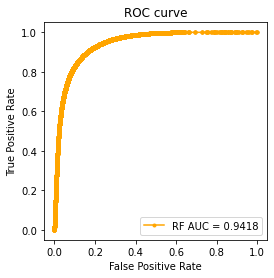

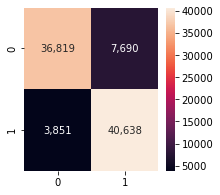

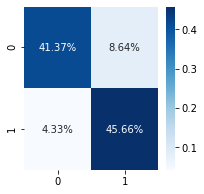

In [15]:
# AUC
probs = np.array(pred_prob(test_iter, net))[:, 1]

rf_auc = roc_auc_score(test_label, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model81
rf_fpr, rf_tpr, _ = roc_curve(test_label, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(test_label, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()